# Import

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import statsmodels

print("pandas version: {}".format(pd.__version__))
print("statsmodels version: {}".format(statsmodels.__version__))

pandas version: 1.4.3
statsmodels version: 0.13.2


# Load Data

In [2]:
# Load the data as dataframe
clu0 = pd.read_csv('https://raw.githubusercontent.com/chenyrae/QMA2/main/clu0.csv')
clu0.head()

,Unnamed: 0.1,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,...,london_imd_decile,imd,income,employment,edu_ski_tra,health_depri,crime,hous_serv,living_env,cluster_id
0,2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,...,6,19.402,0.086,0.086,5.804,-0.102,-1.032,40.103,40.535,0
1,4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,...,6,19.837,0.117,0.059,14.798,-0.359,-0.147,45.171,26.888,0
2,8,E01000010,Barking and Dagenham 015C,E02000016,Barking and Dagenham 015,E09000002,Barking and Dagenham,E12000007,London,2840,...,2,32.437,0.169,0.073,11.762,-0.002,1.214,50.580,47.932,0
3,26,E01000029,Barking and Dagenham 001C,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,1602,...,5,22.503,0.113,0.075,17.349,-0.280,0.350,47.510,21.974,0
4,28,E01000031,Barking and Dagenham 002A,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,1617,...,5,22.672,0.126,0.075,12.953,0.046,0.919,34.140,27.703,0


In [3]:
# Select both independent variables and dependent variables
df_clu0=clu0[['imd','income','employment','edu_ski_tra','health_depri','crime','hous_serv','living_env',
                   'm_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density']]

# Correlation

In [4]:
# Show the correlation of these variables
corr = df_clu0.corr()
corr.style.background_gradient(cmap='coolwarm')

,imd,income,employment,edu_ski_tra,health_depri,crime,hous_serv,living_env,m_price,minimum_ni,m_monrevie,m_hostlist,m_avaliabl,density
imd,1.000000,0.741810,0.636775,0.272094,0.538300,0.455002,0.365818,0.309617,0.012903,-0.019611,0.011852,-0.024527,-0.105734,0.166166
income,0.741810,1.000000,0.788758,0.266211,0.375247,0.101484,0.072126,-0.088447,-0.008429,-0.036232,0.010725,-0.007668,-0.041905,0.048726
employment,0.636775,0.788758,1.000000,0.145604,0.379919,0.081367,-0.100364,-0.123646,0.028538,-0.029401,0.014890,0.039529,-0.046557,0.041108
edu_ski_tra,0.272094,0.266211,0.145604,1.000000,-0.048439,-0.038387,0.188821,-0.249327,-0.158749,-0.006015,0.083669,-0.261432,0.193557,-0.290432
health_depri,0.538300,0.375247,0.379919,-0.048439,1.000000,0.178578,-0.081913,0.192630,0.019287,-0.030824,-0.026390,0.078220,-0.207812,0.158836
crime,0.455002,0.101484,0.081367,-0.038387,0.178578,1.000000,-0.031395,0.250697,0.007516,-0.014774,-0.030834,0.057633,-0.093428,0.111948
hous_serv,0.365818,0.072126,-0.100364,0.188821,-0.081913,-0.031395,1.000000,-0.052652,-0.085583,0.024808,-0.004957,-0.177149,0.060421,-0.052554
living_env,0.309617,-0.088447,-0.123646,-0.249327,0.192630,0.250697,-0.052652,1.000000,0.168028,0.008960,0.003909,0.126930,-0.190993,0.375732
m_price,0.012903,-0.008429,0.028538,-0.158749,0.019287,0.007516,-0.085583,0.168028,1.000000,0.021666,-0.019491,0.228956,-0.055946,0.248791
minimum_ni,-0.019611,-0.036232,-0.029401,-0.006015,-0.030824,-0.014774,0.024808,0.008960,0.021666,1.000000,-0.039028,0.012381,0.075943,0.007093


# VIF

In [5]:
df_clu0_living_env=clu0[['living_env','m_price','minimum_ni','m_monrevie','m_hostlist','m_avaliabl','density']]

# Check VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break
    return df

df_selected_VIF_living_env = drop_column_using_vif_(df_clu0_living_env.drop('living_env', axis=1))
print("The columns remaining after VIF selection are:")
print(df_selected_VIF_living_env.columns)

The columns remaining after VIF selection are:
Index(['m_price', 'minimum_ni', 'm_monrevie', 'm_hostlist', 'm_avaliabl',
       'density'],
      dtype='object')


# Multiple Linear Regression of all independent variables

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

# Show multiple linear regression
model_living_env = sm.OLS(endog=df_clu0_living_env[['living_env']], exog=sm.add_constant(df_selected_VIF_living_env)).fit()
model_living_env.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             living_env   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     59.54
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           3.83e-67
Time:                        16:07:01   Log-Likelihood:                -6381.1
No. Observations:                1720   AIC:                         1.278e+04
Df Residuals:                    1713   BIC:                         1.281e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9515      0.681     49.835      0.000      32.615      35.288
m_price        0.0100      0.003      3.081      0.002       0.004       0.016
minimum_ni     0.0286      0.037      0.767      0.443      -0.044       0.102
m_monrevie    -0.0083      0.323     -0.026      0.980      -0.643       0.626
m_hostlist     0.0045      0.010      0.447      0.655      -0.015       0.024
m_avaliabl    -9.3950      1.321     -7.111      0.000     -11.986      -6.804
density     1.272e+04    863.083     14.744      0.000     1.1e+04    1.44e+04
==============================================================================
Omnibus:                      217.160   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.760
Skew:                           0.811   Prob(JB):                     1.90e-86
Kurtosis:                       4.697   Cond. No.                     4.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Linear Regression in social perspective

In [9]:
# As the p value of minimum_ni, m_monrevie, m_monrevie are lower than 0.05, these variables are dropeed.
# This study focuses more on social perspective, the price variable is not discussed here.
model_liv = sm.formula.ols(' living_env ~ m_avaliabl + density', data=df_clu0_living_env).fit()
model_liv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             living_env   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     172.3
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           6.53e-69
Time:                        16:21:45   Log-Likelihood:                -6386.7
No. Observations:                1720   AIC:                         1.278e+04
Df Residuals:                    1717   BIC:                         1.280e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.9105      0.527     66.215      0.000      33.876      35.945
m_avaliabl    -9.5350      1.303     -7.315      0.000     -12.091      -6.978
density     1.347e+04    820.678     16.412      0.000    1.19e+04    1.51e+04
==============================================================================
Omnibus:                      214.981   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.126
Skew:                           0.808   Prob(JB):                     8.64e-85
Kurtosis:                       4.671   Cond. No.                     3.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

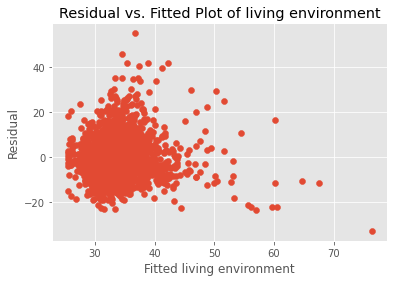

In [10]:
# Residual figure with fitted Plot of living environment
plt.scatter(model_liv.fittedvalues, model_liv.resid)
plt.xlabel('Fitted living environment')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of living environment')
plt.show()

# Map
Future Airbnb Guidance with borough map

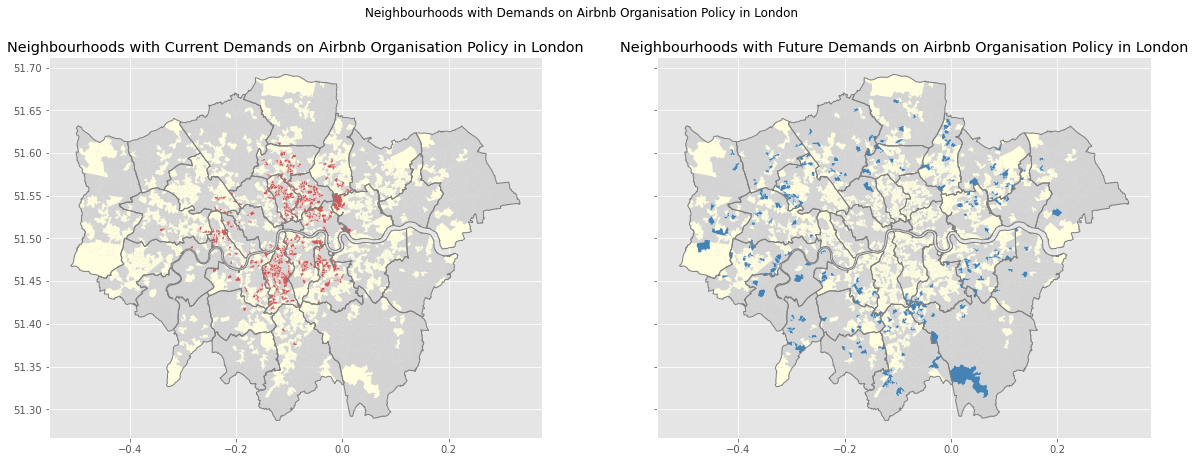

In [23]:
from matplotlib import pyplot
import geopandas
from shapely import geometry

# Select neighborhoodds with high Airbnb density, high values in living_env index and low availability of Airbnb
H_Living = clu0[clu0['living_env'] > clu0['living_env'].median()]
H_D = clu0[clu0['density'] > clu0['density'].median()]
L_A = clu0[clu0['m_avaliabl'] < clu0['m_avaliabl'].median()]
M0 = H_Living.merge(H_D, on = [ 'LSOA11CD'], how = 'inner')
restriction0 = M0.merge(L_A, on = [ 'LSOA11CD'], how = 'inner')
restriction = restriction0[['LSOA11CD']]

# join spatial data to neighbourhoods 
LSOAairbnb = gpd.read_file("densityshapefile/LSOAairbnb.shp")
clu0map = clu0[['LSOA11CD']]
clu0map1 = LSOAairbnb.merge(clu0map, on='LSOA11CD', how='inner')

Borough = gpd.read_file("https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true")

fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize = (20,7), sharex=True, sharey=True)



restrictionmap = LSOAairbnb.merge(restriction, on='LSOA11CD', how='inner')


# Select neighborhoodds with low Airbnb density, low values in living_env index index and high availability
L_Living = clu0[clu0['living_env'] < clu0['living_env'].median()]
L_D = clu0[clu0['density'] < clu0['density'].median()]
L_A = clu0[clu0['m_avaliabl'] < clu0['m_avaliabl'].median()]

# extract future neighborhood
I0 = L_Living.merge(L_D, on = [ 'LSOA11CD'], how = 'inner')
improvment0 = I0.merge(L_A, on = [ 'LSOA11CD'], how = 'inner')
improvment = improvment0[['LSOA11CD']]

# join spatial data to neighbourhoods 
improvementmap = LSOAairbnb.merge(improvment, on='LSOA11CD', how='inner')

# Overall Map


LSOAairbnb.to_crs(epsg=4326).plot(ax=ax1, color='lightgrey')
LSOAairbnb.plot(ax=ax, cmap = 'OrRd', scheme='natural_breaks', edgecolor="grey", linewidth=.1,
                legend = True, legend_kwds={'loc': 'upper right',  'fmt':"{:.4f}"})

clu0map1.plot(ax=ax1, color= 'lightyellow', edgecolor="white", linewidth=.05)
restrictionmap.plot(ax=ax1, color= 'indianred', edgecolor="white", linewidth=.2)
ax1.set_title('Neighbourhoods with Current Demands on Airbnb Organisation Policy in London')
Borough.to_crs(epsg=4326).plot(ax=ax1, facecolor='none', edgecolor="grey",linewidth=1)


LSOAairbnb.to_crs(epsg=4326).plot(ax=ax2, color='lightgrey')
LSOAairbnb.plot(ax=ax, cmap = 'OrRd', edgecolor="grey", linewidth=.1,
                scheme='natural_breaks', legend = True)

clu0map1.plot(ax=ax2, color= 'lightyellow', edgecolor="white", linewidth=.05)
improvementmap.plot(ax=ax2, color= 'steelblue', edgecolor="white", linewidth=.2)
ax2.set_title('Neighbourhoods with Future Demands on Airbnb Organisation Policy in London')
Borough.to_crs(epsg=4326).plot(ax=ax2, facecolor='none', edgecolor="grey",linewidth=1)


fig.suptitle('Neighbourhoods with Demands on Airbnb Organisation Policy in London')
plt.savefig('Neighbourhoods with Demands on Airbnb Organisation Policy in London')







# more availability, more spaces free ,值越高，来年的空房越多
# 每个步骤是干嘛的，简单分析一些数字（P value, R方代表什么？...)
# Limitation （topic, methodology) & future work 
1. this study research on the year 2019, when is before covid 19. It is lack of resilience of big event?
2. 